## GRACE SPATIO-TEMPORAL DATA ANALYSIS
### TARGET AREA:- GREENLAND


### Import system related and basic libraries

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

### Read the GRACE DATA
`Using NASA-JPL GRACE`

`Import read from grace_read module`

```from grace_read.read import read```

In [2]:
from grace_read.read import read

In [3]:
# Define the folder path
root_dir = "/home/shivam/2020-21-1/CE678A/Project-Group3Musketeers/grace-temporal-data/NASA-JPL-GRACE/DDK1/"

# Get the files path in root directory
files_path = [root_dir+file_n for file_n in os.listdir(root_dir)]

# Read the data
data = read(files_path)

print("Files read:-\t", len(files_path), "\nStructre of the data:-\t", data.keys())

Files read:-	 165 
Structre of the data:-	 dict_keys(['header_info', 'sc_coeffs_mat'])


### Compute monthly anomaly for the given data

`Import anomaly module from preprocessing`

```from grace_fo_stda.preprocessing.anomaly import anomaly```

In [4]:
from grace_fo_stda.preprocessing.anomaly import anomaly

In [5]:
# Get the monthly anomaly of sc_coeffs
sc_anomaly = anomaly(data)

print("Structure of anomaly data:-\t", sc_anomaly.keys())

Structure of anomaly data:-	 dict_keys(['header_info', 'sc_anomaly'])


`View sample anomaly obtained previously`

```imshow(log(abs(anomaly_sample))```

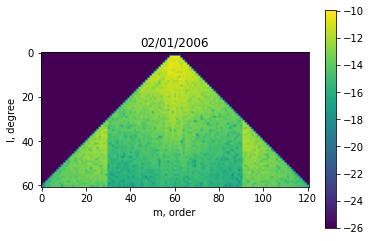

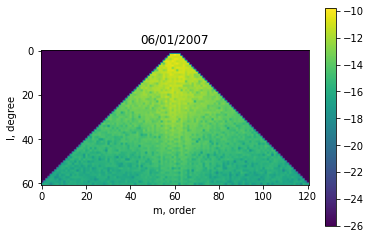

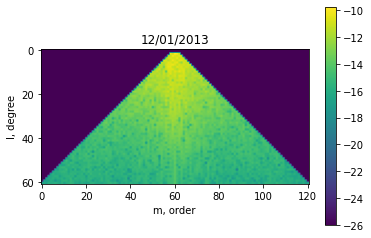

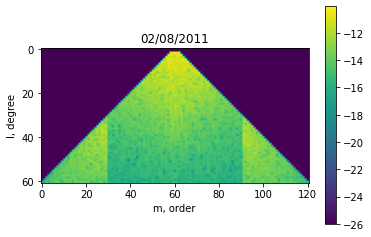

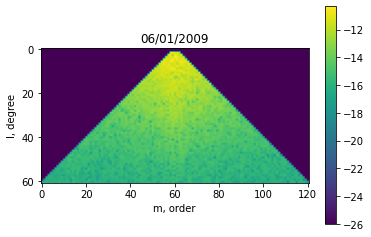

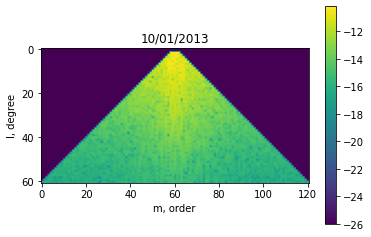

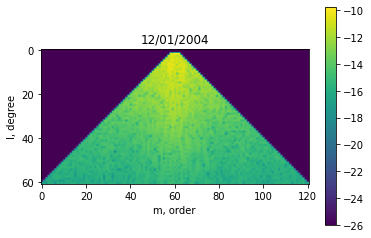

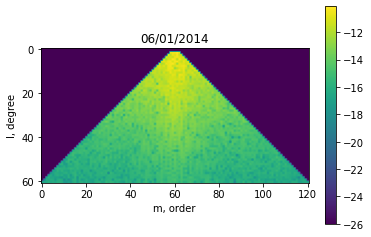

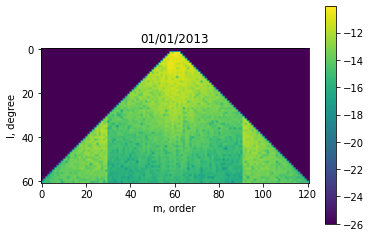

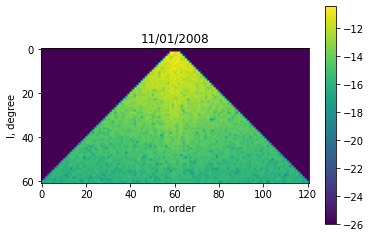

In [6]:
for i in range(10):

    # Copy the anomaly data for i-th files_path
    lm_coeffs = np.copy(sc_anomaly["sc_anomaly"][i])

    # reconstruct the sc-coeffs in a single band
    lm_coeffs = np.concatenate((np.fliplr(lm_coeffs[:, 1:, 1]), lm_coeffs[:, :, 0]), axis=1)
    lm_coeffs[np.where(np.abs(lm_coeffs)<1E-20)] = 1E-26
    # PLot the ressulte with anomaly as log(abs(anomaly))
    plt.imshow(np.log10(np.abs(lm_coeffs)))
    plt.colorbar()
    plt.title(sc_anomaly["header_info"][i]["Start date"].strftime('%m/%d/%Y'))
    plt.xlabel("m, order")
    plt.ylabel("l, degree")
    plt.show()

### Filter the sc_anomaly to remove noise

`Import filters module from preprocessing`

```from grace_fo_stda.preprocessing.filters import gauss_filter```

In [7]:

from grace_fo_stda.preprocessing.filters import gauss_filter

`Denoise the sc coefficients anomaly`

In [8]:
# Apply the gaussian filter to sc anomaly
filtered_sc_anomaly = gauss_filter(sc_anomaly, gaussian_blur=np.float32([0.5, 0.1]))

print("Structure of filtered anomaly data:-\t", filtered_sc_anomaly.keys())

Structure of filtered anomaly data:-	 dict_keys(['header_info', 'sc_anomaly'])


`View sample anomaly obtained previously`

```imshow(log(abs(filtered_anomaly_sample))```

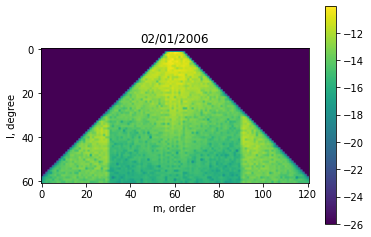

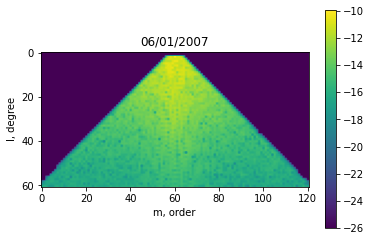

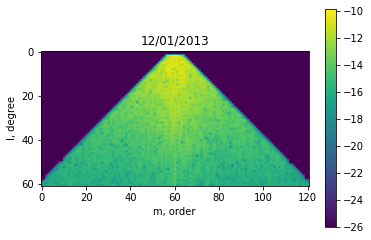

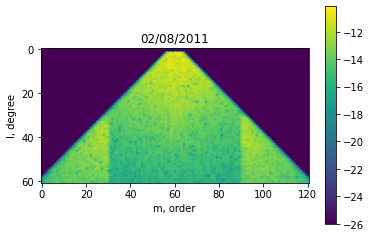

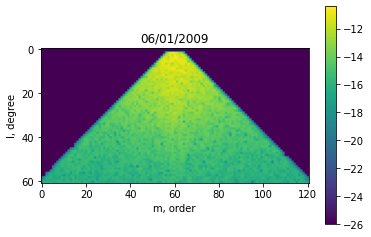

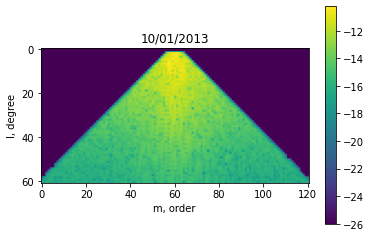

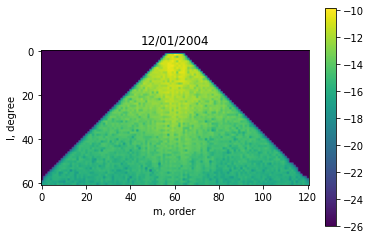

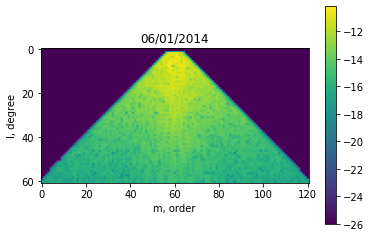

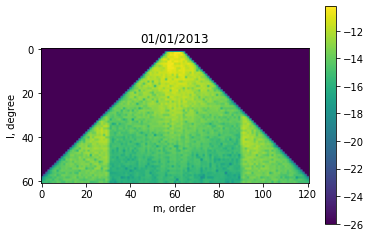

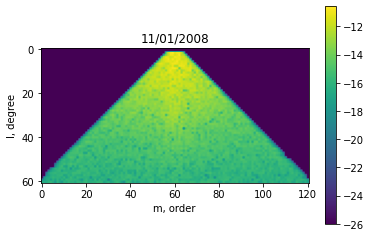

In [9]:
for i in range(10):

    # Copy the anomaly data for i-th files_path
    lm_coeffs = np.copy(filtered_sc_anomaly["sc_anomaly"][i])

    # reconstruct the sc-coeffs in a single band
    lm_coeffs = np.concatenate((np.fliplr(lm_coeffs[:, 1:, 1]), lm_coeffs[:, :, 0]), axis=1)
    lm_coeffs[np.where(np.abs(lm_coeffs)<1E-20)] = 1E-26
    # PLot the ressulte with anomaly as log(abs(anomaly))
    plt.imshow(np.log10(np.abs(lm_coeffs)))
    plt.colorbar()
    plt.title(filtered_sc_anomaly["header_info"][i]["Start date"].strftime('%m/%d/%Y'))
    plt.xlabel("m, order")
    plt.ylabel("l, degree")
    plt.show()

### Get the SMD(Surface mass density) anomaly

`Import GravityField class from pyhsycs module`

```from physics.field import GravityField```

In [10]:
# Import GravityField class
from physics.field import GravityField

In [11]:
# Create gravity processor object
gravity_processor = GravityField()

`Load parameters(LAT, LONG) specific to GREENLAND`

In [12]:
# Load greenland params from the ctchms.mat and ctchmntindx3.mat
gravity_processor.load_location_mask("GREENLAND")

`Compute SMD with the smd() function`

In [13]:
smd = gravity_processor.smd(filtered_sc_anomaly)

print("Structure of smd anomaly data:-\t", smd.keys())

Structure of smd anomaly data:-	 dict_keys(['header_info', 'smd_anomaly'])


`View sample smd anomaly obtained previously`

```imshow(log(abs(smd_sample))```

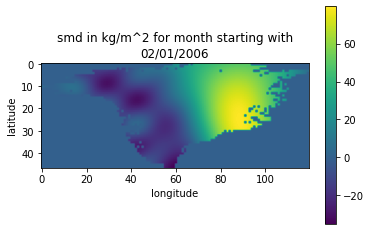

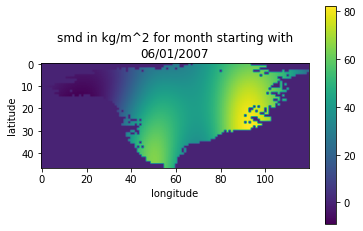

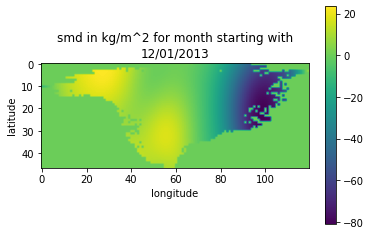

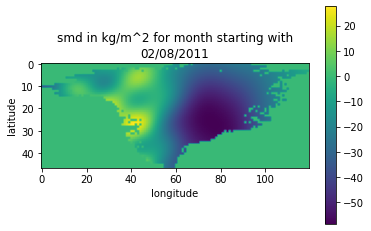

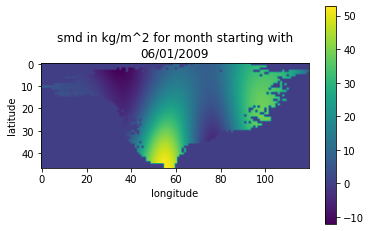

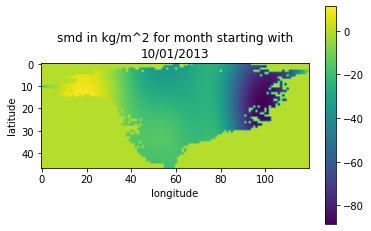

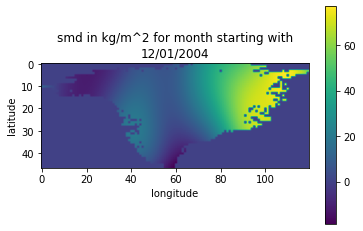

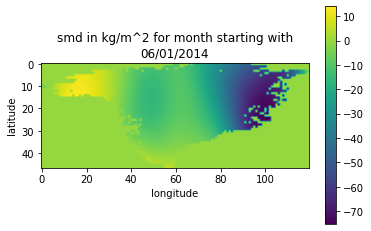

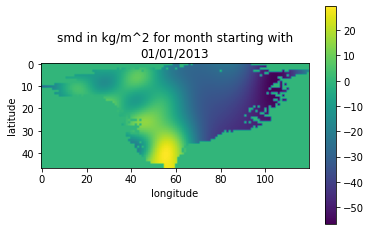

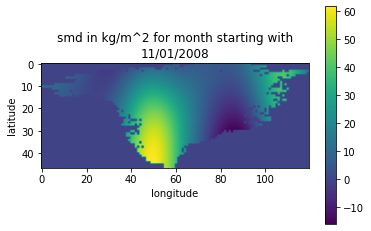

In [14]:
for i in range(10):
    # PLot the result with smd anomaly
    plt.imshow(smd["smd_anomaly"][i])
    plt.colorbar()
    plt.title("smd in kg/m^2 for month starting with\n"+smd["header_info"][i]["Start date"].strftime('%m/%d/%Y'))
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.show()

### Plot the time series for a single (lat, long) and analyse the trend

In [17]:
data_smd = []
pix_idx = 20
for i in range(len(smd["smd_anomaly"])):
    data_smd.append([smd["header_info"][i]["Start date"].year+smd["header_info"][i]["Start date"].month/12-2002,
                     smd["smd_anomaly"][i][gravity_processor.smd_idx[pix_idx][0],
                                           gravity_processor.smd_idx[pix_idx][1]],
                     smd["header_info"][i]["Start date"]])

data_smd = np.array(data_smd)
data_smd = data_smd[np.argsort(data_smd[:, 0]), :]
def smooth(inp, box_pts):
    """

    :param inp:
    :param box_pts:
    :return:
    """
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(inp, box, mode='same')
    return y_smooth
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_smd[:, 2], y=smooth(data_smd[:, 1], 6),
                         mode='lines+markers', name="SMD anomaly from data"))
fig.update_layout(
    title = 'SMD anomaly time Series for position '+"lat:-"+
            str(gravity_processor.lat[pix_idx])+"(rad) long:-"+str(gravity_processor.long[pix_idx])+"(rad)",
    xaxis_tickformat = '%d %B (%a)<br>%Y',
    yaxis_title = "SMD kg/m^2",
    xaxis_title = "Time"
)
fig.show()

### Fit multiple models to this temporal variation for predictions

`Import Model class from models module`

```import models.time_series_regression.Model as model```

In [18]:
# import Model from time_series_regression
from models.time_series_regression import Model as model

# define the model object
time_series_model = model(gravity_processor)

# load parameters
time_series_model.load_data(smd)

# Fit the smd data
time_series_model.fit()

### Reconstruct time series

In [19]:
x = np.ones([np.size(data_smd[:, 0]), 3])
x[:, 0] = data_smd[:, 0]+2002
x[:, 1] = gravity_processor.lat[pix_idx]
x[:, 2] = gravity_processor.long[pix_idx]
y = time_series_model.reconstruct(x)

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_smd[:, 2], y=y[2], mode='lines', name = "Polynomail fit"))
fig.add_trace(go.Scatter(x=data_smd[:, 2], y=y[1], mode='lines', name = "Linear fit"))
fig.add_trace(go.Scatter(x=data_smd[:, 2], y=y[0], mode='lines', name = "RFR fit"))
fig.add_trace(go.Scatter(x=data_smd[:, 2], y=data_smd[:, 1], mode='lines', name = "Actual"))
fig.update_layout(
    title = 'SMD anomaly time Series for position '+"lat:-"+
            str(gravity_processor.lat[pix_idx])+"(rad) long:-"+str(gravity_processor.long[pix_idx])+"(rad)",
    xaxis_tickformat = '%d %B (%a)<br>%Y',
    yaxis_title = "SMD kg/m^2",
    xaxis_title = "Time"
)
fig.show()

### Seasonal changes in month for the same location

In [21]:
x = np.ones([12, 3])
x[:, 0] = np.arange(1, 13, 1)+2007
x[:, 1] = gravity_processor.lat[pix_idx]
x[:, 2] = gravity_processor.long[pix_idx]
y = time_series_model.reconstruct(x)

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x[:, 0]-2014, y=y[2], mode='lines', name = "Polynomail fit"))
fig.add_trace(go.Scatter(x=x[:, 0]-2014, y=y[1], mode='lines', name = "Linear fit"))
fig.add_trace(go.Scatter(x=x[:, 0]-2014, y=y[0], mode='lines', name = "RFR fit"))
fig.update_layout(
    title = 'Seasonal variation for different months '+"lat:-"+
            str(gravity_processor.lat[pix_idx])+"(rad) long:-"+str(gravity_processor.long[pix_idx])+"(rad)",
    yaxis_title = "SMD kg/m^2",
    xaxis_title = "Time"
)
fig.show()

### Analyse the mean SMD anomaly over whole Greenland

In [23]:
data_mean_smd = []
for i in range(len(smd["smd_anomaly"])):
    data_mean_smd.append([smd["header_info"][i]["Start date"].year+smd["header_info"][i]["Start date"].month/12-2002,
                     np.mean(smd["smd_anomaly"][i]),
                     smd["header_info"][i]["Start date"]])

data_mean_smd = np.array(data_mean_smd)
data_mean_smd = data_mean_smd[np.argsort(data_mean_smd[:, 0]), :]

fig = go.Figure()

fig.add_trace(go.Scatter(x=data_mean_smd[:, 2], y=smooth(data_mean_smd[:, 1], 4),
                         mode='lines+markers', name="SMD anomaly from data"))
fig.update_layout(
    title = 'SMD anomaly time Series, mean over the whole area',
    xaxis_tickformat = '%d %B (%a)<br>%Y',
    yaxis_title = "SMD kg/m^2",
    xaxis_title = "Time"
)
fig.show()

In [24]:
# define the model object
time_series_model_mean = model(gravity_processor)

# load parameters
time_series_model_mean.train_x = np.float32([data_mean_smd[:, 0]+2002]).T
time_series_model_mean.train_y = data_mean_smd[:, 1].flatten()

# Fit the smd data
time_series_model_mean.fit()

In [25]:
y = time_series_model_mean.reconstruct()

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_mean_smd[:, 2], y=y[2], mode='lines', name = "Polynomail fit"))
fig.add_trace(go.Scatter(x=data_mean_smd[:, 2], y=y[1], mode='lines', name = "Linear fit"))
fig.add_trace(go.Scatter(x=data_mean_smd[:, 2], y=y[0], mode='lines', name = "RFR fit"))
fig.add_trace(go.Scatter(x=data_mean_smd[:, 2], y=data_mean_smd[:, 1], mode='lines', name = "Actual"))
fig.update_layout(
    title = 'SMD anomaly time Series for mean over whole area',
    xaxis_tickformat = '%d %B (%a)<br>%Y',
    yaxis_title = "SMD kg/m^2",
    xaxis_title = "Time"
)
fig.show()